# Preliminary operations

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import data

In [ ]:
# define directory path
directory = "drive/MyDrive/Progetto Data Mining 2/CODICE PROGETTO/Time Series/DATASET/"

# import ts data
df_train = pd.read_csv(directory + "Approximated/ts_data_TRAIN_PAA.csv", index_col="Unnamed: 0")
df_test = pd.read_csv(directory + "Approximated/ts_data_TEST_PAA.csv", index_col="Unnamed: 0")

# get ts values
X_train = df_train.values
X_test = df_test.values

df_info_train = pd.read_csv(directory + "RavdessAudioOnlyNumpy__Y_train.csv")
df_info_test = pd.read_csv(directory + "RavdessAudioOnlyNumpy__Y_test.csv")

# import emotion data
y_train = df_info_train["emotion"]
y_test = df_info_test["emotion"]

# check length
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
df_info_train.loc[4]

modality                                 audio-only
vocal_channel                                speech
emotion                                        calm
emotional_intensity                          normal
statement              Kids are talking by the door
repetition                                      1st
actor                                             1
sex                                               M
filename                   03-01-02-01-01-01-01.wav
Name: 4, dtype: object

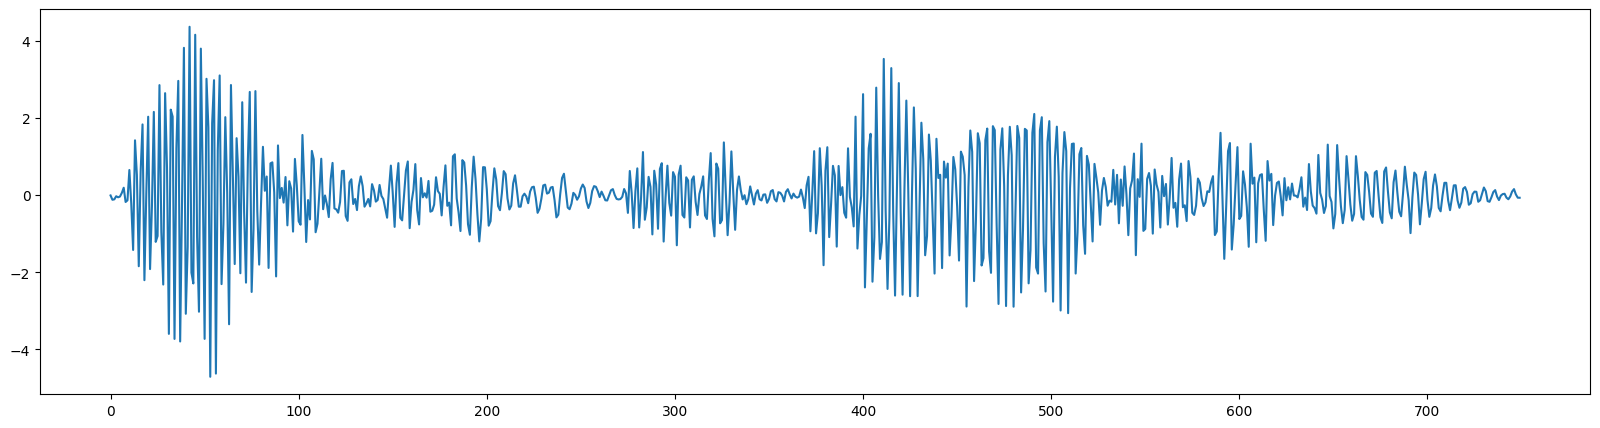

In [ ]:
# plot the audio wave
plt.figure(figsize=(20,5))

plt.plot(X_train[4, 500:1250])

plt.show()

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

# standardization
scaler = TimeSeriesScalerMinMax(
    value_range = (1, 2)
)

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

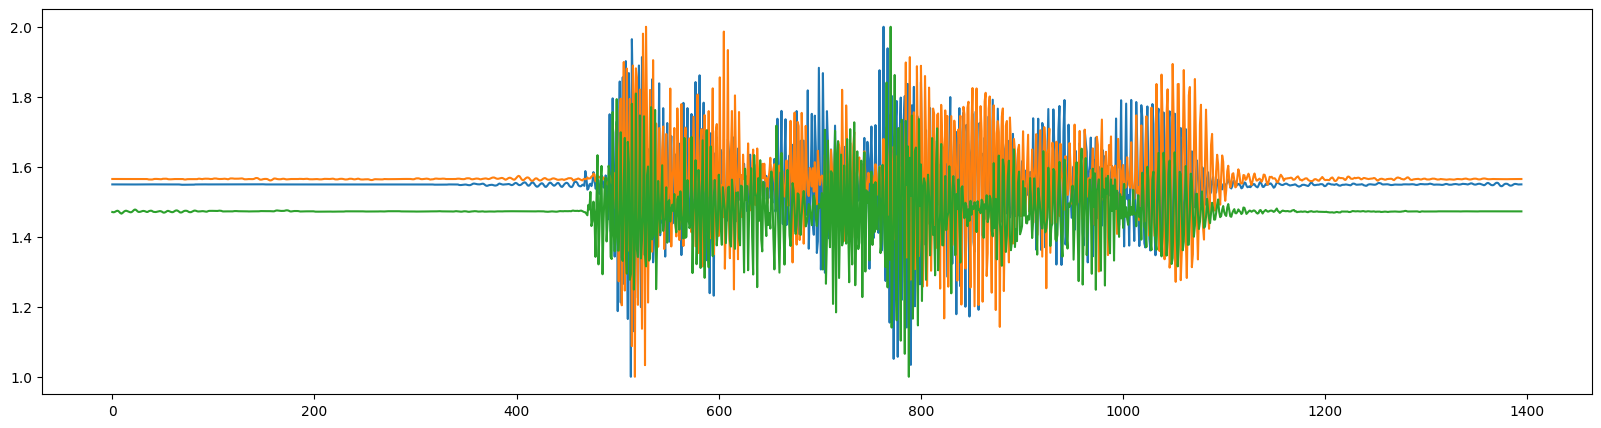

In [ ]:
# plot the audio wave
plt.figure(figsize=(20,5))

for ts in X_train[:3]:
  plt.plot(ts)

plt.show()

# Matrix Profile

https://github.com/target/matrixprofile-ts

https://github.com/TDAmeritrade/stumpy

In [ ]:
!pip install matrixprofile-ts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matrixprofile import *

In [ ]:
x_speech = X_train[4, 500:1250]

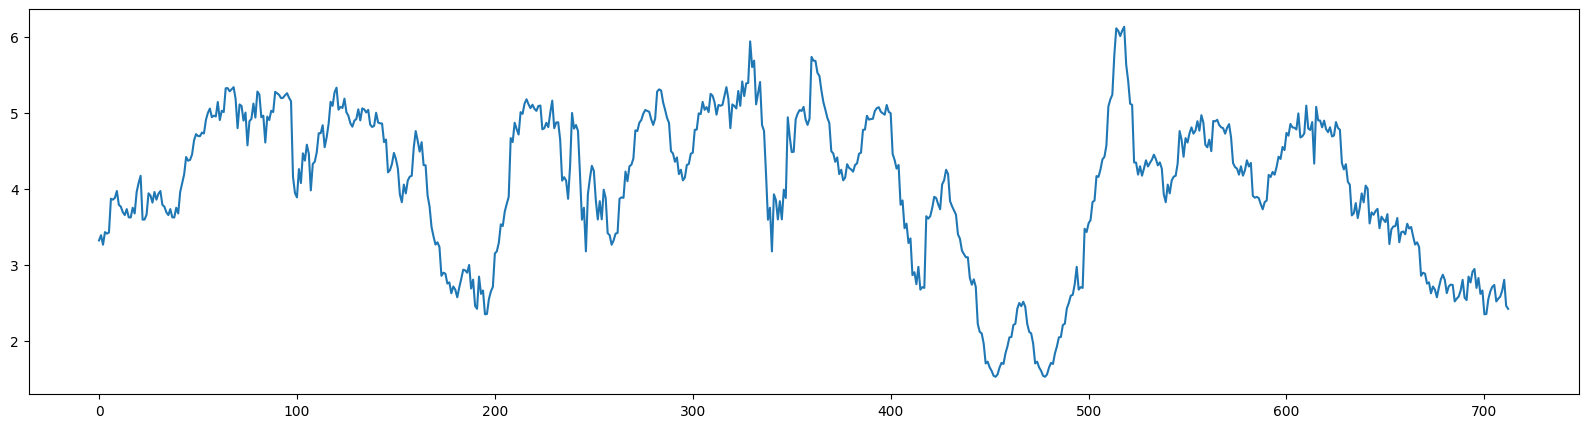

In [ ]:
w = 38
mp, mpi = matrixProfile.stomp(x_speech, w)

# plot the audio wave
plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()

In [ ]:
mp[:10]

array([3.32392171, 3.39279705, 3.26721489, 3.4333284 , 3.41351176,
       3.42793309, 3.87193765, 3.86002299, 3.8839956 , 3.97358015])

In [ ]:
mpi[:10]

array([260., 258., 259., 260., 261., 262., 263.,  29., 265.,  31.])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


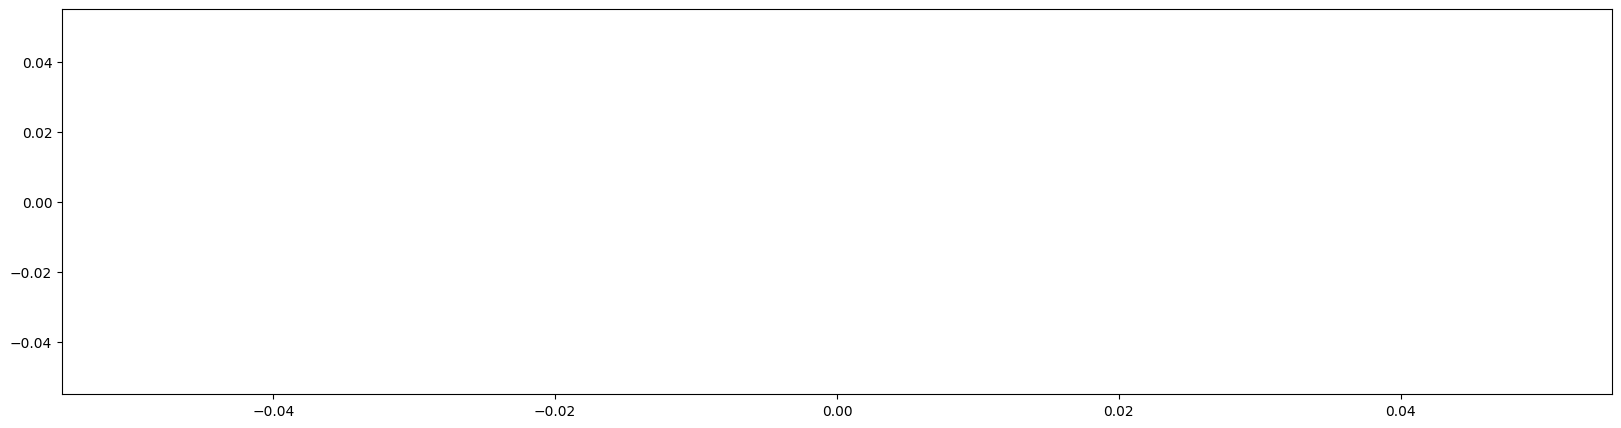

In [ ]:
window = 75
ts_series = pd.Series(x_speech)
ts_log_mov_diff = pd.Series(np.log(ts_series) - np.log(ts_series).rolling(window, center=False).mean(), index=ts_series.index)

# plot the audio wave
plt.figure(figsize=(20,5))
plt.plot(ts_log_mov_diff)
plt.show()

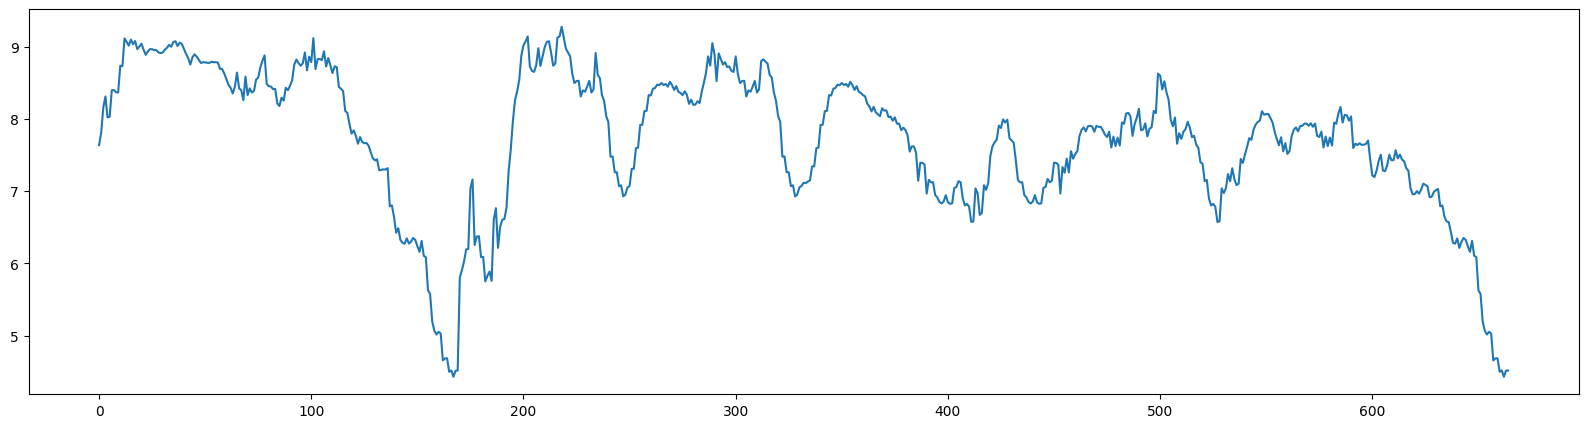

In [ ]:
w = 75
mp, mpi = matrixProfile.stomp(ts_log_mov_diff.values[11:], w)

# plot the audio wave
plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()

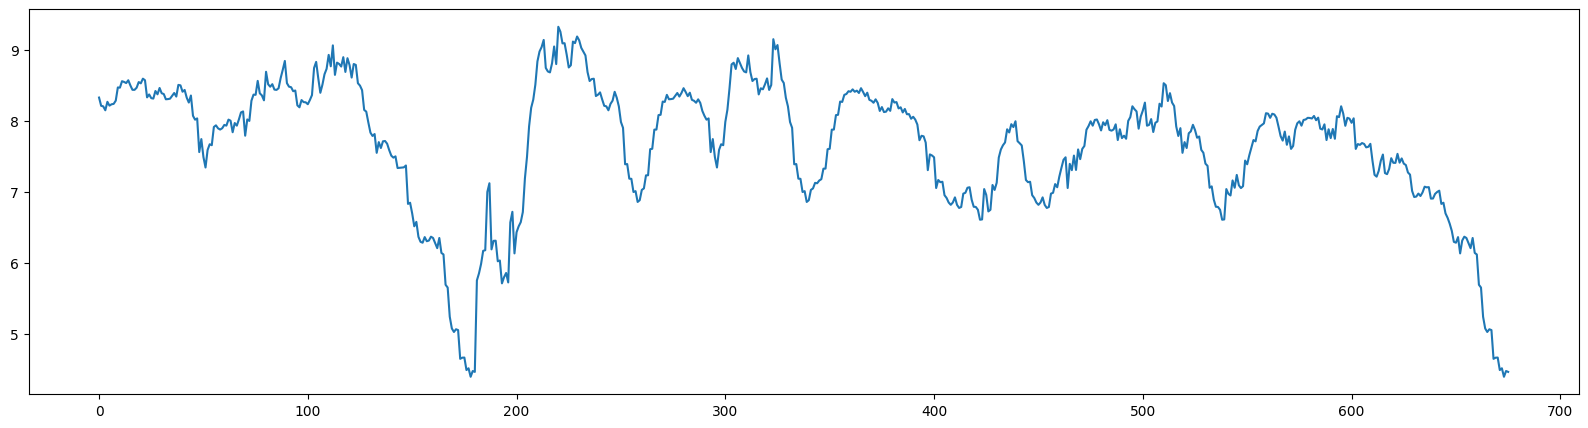

In [ ]:
w = 75
mp, mpi = matrixProfile.stomp(x_speech, w)

# plot the audio wave
plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()

# Motif Discovery

In [ ]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

mo, mod  = motifs.motifs(x_speech, (mp, mpi), max_motifs=10)

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [ ]:
mo

[[453, 478],
 [103, 195, 237, 648, 679, 700],
 [145, 322, 415, 499, 548, 582],
 [173, 215, 627],
 [2, 24, 259, 285, 347],
 [50, 72, 125, 376, 524, 602]]

In [ ]:
mod

[1.531351937177284,
 2.3526728790470646,
 2.677348130325624,
 2.858774992617617,
 3.267214888097833,
 4.113990595746383]

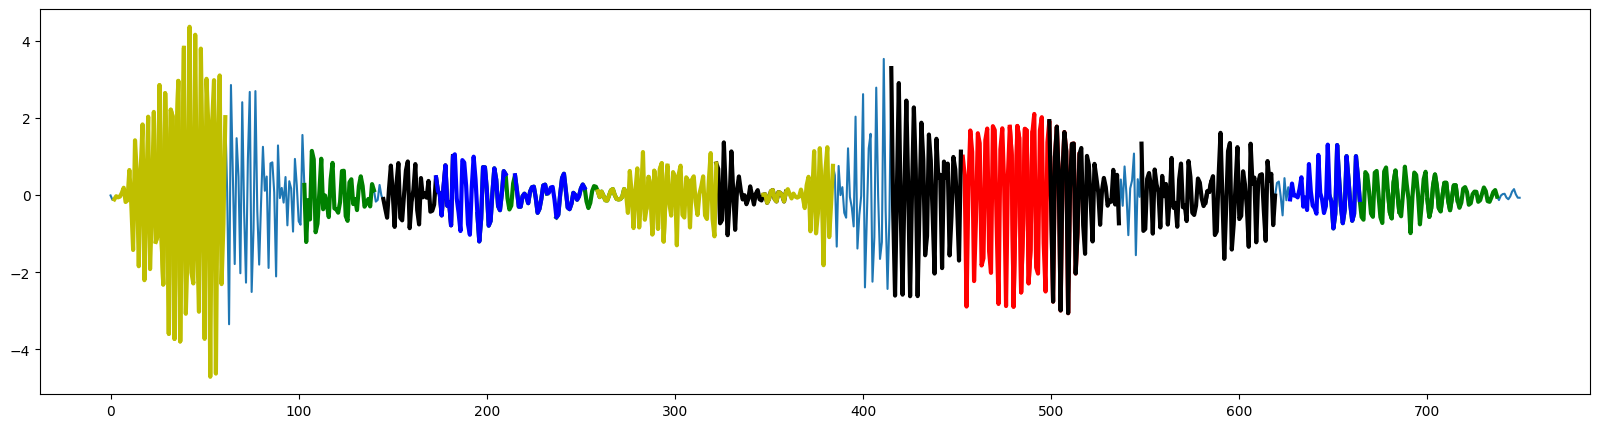

In [120]:
# plot the audio wave
plt.figure(figsize=(20,5))

plt.plot(x_speech)

colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = x_speech[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.savefig("motifs_speech.pdf")
plt.show()

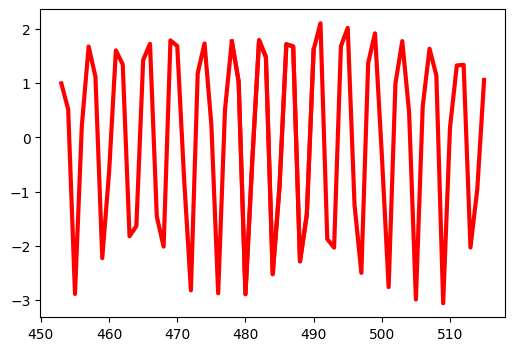

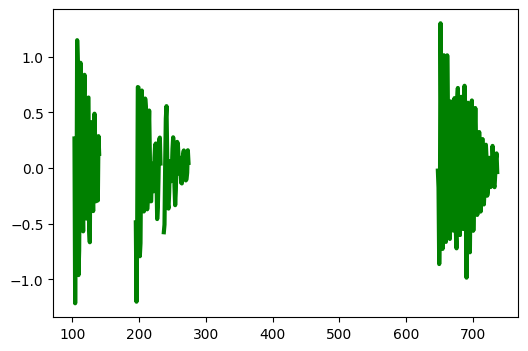

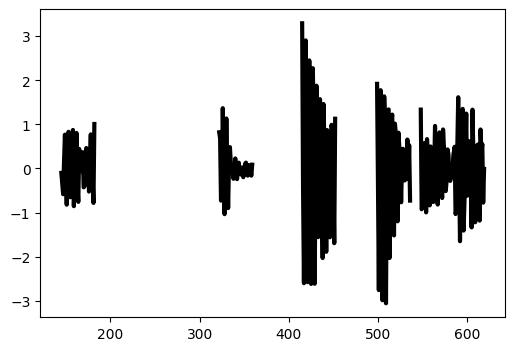

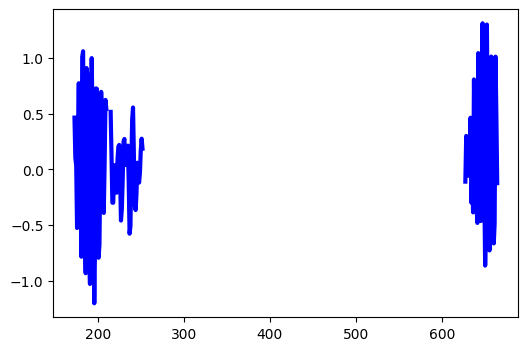

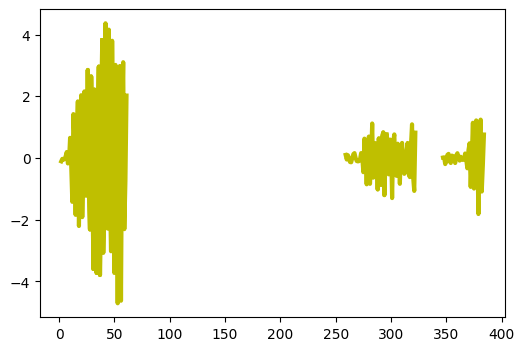

In [128]:
for m, d, c in zip(mo, mod, colors):
    plt.figure(figsize=(6,4))
    for i in m:
        m_shape = x_speech[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.savefig("motif_speech" + str(i) + ".pdf")
    plt.show()

# Anomaly Discovery

In [ ]:
from matrixprofile.discords import discords

Parameters
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord

Returns
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [121]:
anoms = discords(mp, ex_zone=3, k=5)

In [122]:
anoms

array([518, 514, 329, 360, 363])

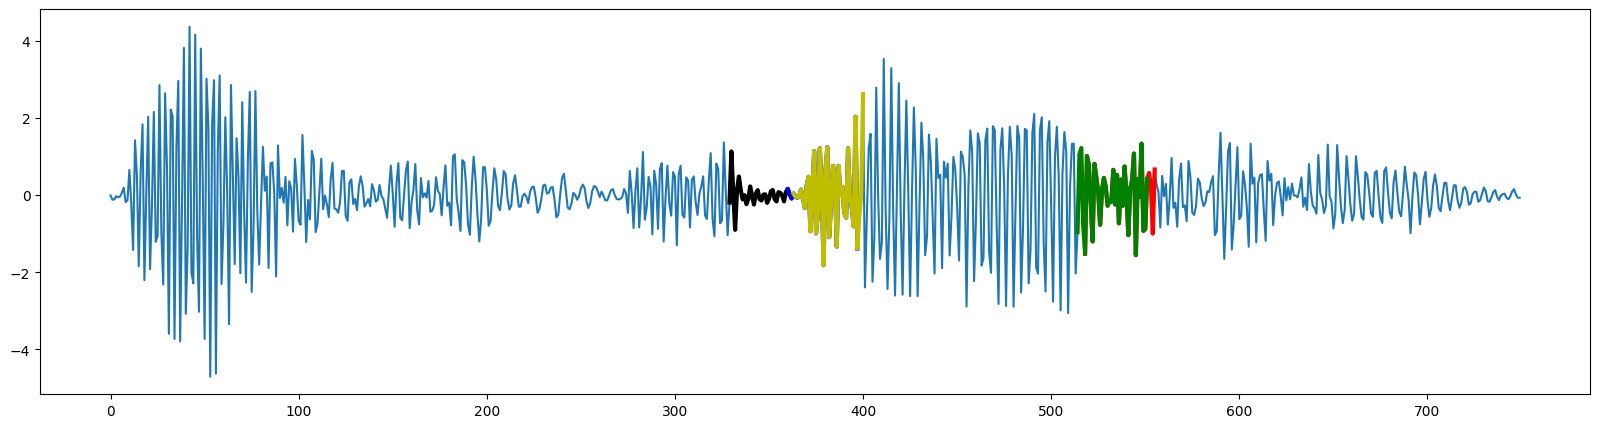

In [124]:
plt.figure(figsize=(20,5))
plt.plot(x_speech)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = x_speech[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.savefig("anomalies_speech.pdf")
plt.show()

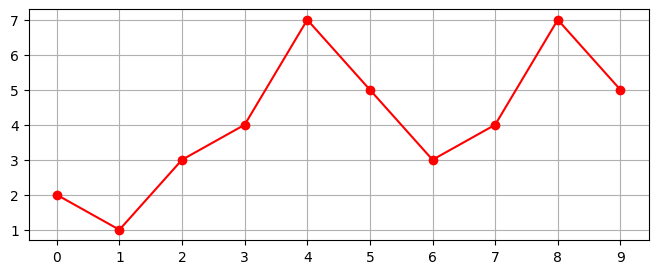

In [ ]:
plt.figure(figsize=(8, 3))
x = np.array([2,1,3,4,7,5,3,4,7,5])
plt.plot(range(len(x)), x, marker='o', color='r')
plt.xticks(range(len(x)))
plt.grid()
plt.show()

In [ ]:
w = 3
mp = np.array([np.inf] * (len(x) - w + 1))
for i in range(len(x) - w + 1):
    #print('a', x[i:i+w])
    for j in range(len(x) - w + 1):
        if i == j:
            continue
        #print('b', x[j:j+w])
        val = 0
        for k in range(w):
            val += np.abs(x[i + k] - x[j + k])
        #print(val)
        mp[i] = min(mp[i], val)
    #print('')


In [ ]:
mp

array([4., 4., 0., 0., 5., 4., 0., 0.])

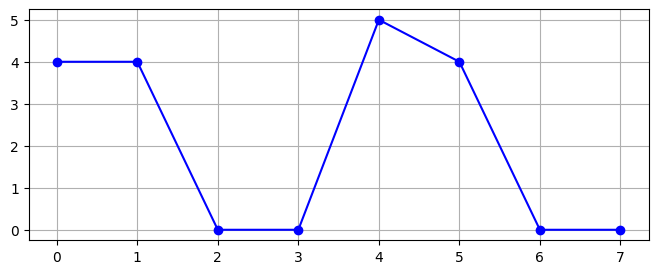

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(mp, marker='o', color='b')
plt.xticks(range(len(mp)))
plt.grid()
plt.show()

In [ ]:
mp, mpi = matrixProfile.naiveMP(X_train[0], m=12)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(mp)
plt.show()

In [ ]:
mp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
mpi

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132.])

In [ ]:
import stumpy # https://stumpy.readthedocs.io/en/latest/api.html

In [ ]:
matrix_profile = stumpy.stump(ts.values.astype(float), m=12)

/Users/riccardo/opt/miniconda3/lib/python3.8/site-packages/stumpy/stump.py:350: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  ndist_counts = core._count_diagonal_ndist(diags, m, n_A, n_B)


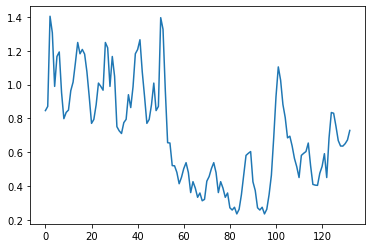

In [ ]:
mp = matrix_profile[:,0]
mpi = matrix_profile[:,1]

plt.plot(mp)
plt.show()